In [1]:
import random

import gym
import numpy as np
import tensorflow as tf
from tensorflow_core import initializers
import matplotlib.pyplot as plt

env = gym.make('Copy-v0')
actions = [(0, 0, 0),
           (0, 0, 1),
           (0, 0, 2),
           (0, 0, 3),
           (0, 0, 4),
           (0, 1, 0),
           (0, 1, 1),
           (0, 1, 2),
           (0, 1, 3),
           (0, 1, 4),
           (1, 0, 0),
           (1, 0, 1),
           (1, 0, 2),
           (1, 0, 3),
           (1, 0, 4),
           (1, 1, 0),
           (1, 1, 1),
           (1, 1, 2),
           (1, 1, 3),
           (1, 1, 4)]

In [2]:
# constants
EPSILON = 0.2
ALPHA = 0.2
GAMMA = 0.9

In [3]:
print('State:', env.observation_space)
print('Action:', env.action_space)
print('Num actions:', len(actions))

State: Discrete(6)
Action: Tuple(Discrete(2), Discrete(2), Discrete(5))
Num actions: 20


In [4]:
# initial state
# for each action:
#   compute features from (state, action)
#   forward pass features
#   output is single q value
# taken: max(q_vals) or random action

def make_input(state, action):
    return np.matrix([state, action[0], action[1], action[2]])

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4,)),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
    # tf.keras.layers.Dense(25, activation='relu', kernel_initializer=initializers.he_normal()),
    tf.keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.he_normal())
])

In [21]:
# inp = make_input(1, (1, 0, 2))
# model(inp).numpy()

In [26]:
all_episode_rewards = []
all_td_errors = []
for i in range(1000):
    observation = env.reset()
    episode_reward = 0
    episode_td_error = 0
    for j in range(20):
        with tf.GradientTape() as tape:
            rand = random.random()
            if rand < EPSILON:
                action = env.action_space.sample()
            else:
                q_vals = []
                # get max q value of actions from the current state
                for poss_action in actions:
                    q_vals.append(model(make_input(observation, poss_action))[0])

                best_idx = np.argmax(q_vals)
                action = actions[best_idx]
                # print('Q vals:', q_vals)
                # print(f'Action taken: {action} with index {best_idx}')

            next_state, reward, done, info = env.step(action)

            # obtain next best q value
            if done:
                max_next_q = 0
                print(f'Episode {i} finished after {j} timesteps')
                break
            else:
                next_q_vals = []
                for next_action in actions:
                    next_q_vals.append(tf.stop_gradient(model(make_input(next_state, next_action))[0]))
                max_next_q = max(next_q_vals)

            # perform updates
            curr_q = model(make_input(observation, action))[0]
            observed_q = reward + (GAMMA * max_next_q)
            td_err = (observed_q - curr_q) ** 2
            # print(f'TD-Error: {td_err[0]}')

            # apply gradients
            grads = tape.gradient(td_err, model.trainable_variables)
            opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            episode_td_error += td_err[0]
            episode_reward += reward
            observation = next_state

    all_episode_rewards.append(episode_reward)
    all_td_errors.append(episode_td_error)

Episode 0 finished after 0 timesteps
Episode 1 finished after 0 timesteps
Episode 2 finished after 0 timesteps
Episode 3 finished after 2 timesteps
Episode 4 finished after 2 timesteps
Episode 5 finished after 1 timesteps
Episode 6 finished after 0 timesteps
Episode 7 finished after 0 timesteps
Episode 8 finished after 0 timesteps
Episode 9 finished after 0 timesteps
Episode 10 finished after 0 timesteps
Episode 11 finished after 0 timesteps
Episode 12 finished after 0 timesteps
Episode 13 finished after 0 timesteps
Episode 14 finished after 1 timesteps
Episode 15 finished after 1 timesteps
Episode 16 finished after 0 timesteps
Episode 17 finished after 1 timesteps
Episode 18 finished after 0 timesteps
Episode 19 finished after 0 timesteps
Episode 20 finished after 0 timesteps
Episode 21 finished after 0 timesteps
Episode 22 finished after 0 timesteps
Episode 23 finished after 0 timesteps
Episode 24 finished after 0 timesteps
Episode 25 finished after 0 timesteps
Episode 26 finished af

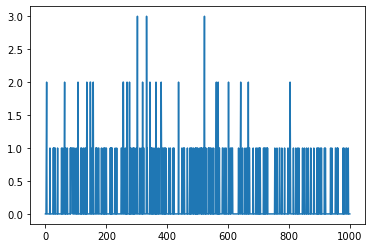

In [32]:
fig = plt.plot(all_episode_rewards)
plt.show()